# **Ouroboros Neurofeedback API: Computing NF scores from observed and predicted human brain activity (EEG, fMRI)**

#### Version: 16th May 2024

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

### Notebook 02

# **Requests**

## **1. Observed brain activity**

**Request:** To the *observed_brain_activity* endpoint of the API, we send a single-channel time series of preprocessed EEG data, as well as some parameters: the sampling frequency of the preprocessed EEG data, the definition of the frequency bands, the specific frequency band to be used for neurofeedback (NF) training, the type of NF regulation, and the NF threshold. 

**Response:** We retrieve the bandpowers, the feedback valence, and the NF score. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mne
import json
import requests

In [2]:
# Define the preprocessed EEG data path. 
preprocessed_eeg_data_path = '../../Neuropolis/ds002336-download/derivatives/'

# Select the subject and condition to use. 
selected_subject = 'sub-xp110'
selected_condition = 'eegfmriNF'

# Define the path of the header file (.vhdr) for this subject and this condition. 
vhdr_path = preprocessed_eeg_data_path + selected_subject + '/eeg_pp/' + selected_subject + '_task-' + selected_condition + '_eeg_pp.vhdr'

In [3]:
# Load the EEG data using the MNE library. 
channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = False)

# Retrieve the sampling frequency. 
sampling_frequency = channels_data.info['sfreq']
sampling_frequency

/var/folders/8y/sg28phf55jv3mkr_l1g50xn40000gn/T/ipykernel_1289/1938147726.py:2: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = False)


200.0

In [4]:
# Identify the C1 channel index. 
c1_channel_index = channels_data.ch_names.index('C1')
c1_channel_index

34

In [5]:
# Export the EEG data into a NumPy array. 
np_channels_data = channels_data.get_data() 

# Check the size of the array. 
np_channels_data.shape

(64, 80200)

In [6]:
# Define the frequency bands of interest. 
frequency_bands = [[1, 4, 'Delta'], [4, 8, 'Theta'], [8, 12, 'Alpha'], [12, 16, 'Sigma'], [16, 30, 'Beta'], [30, 40, 'Gamma']]
frequency_bands

[[1, 4, 'Delta'],
 [4, 8, 'Theta'],
 [8, 12, 'Alpha'],
 [12, 16, 'Sigma'],
 [16, 30, 'Beta'],
 [30, 40, 'Gamma']]

In [7]:
# Define the URL. 
url_observed_brain_activity = 'http://localhost:8000/neurofeedback/observed_brain_activity'

# Define the dictionary. 
# Here we use the first 2 seconds of data for the C1 electrode. Any other 2-second (or longer) interval could be used. 
eeg_dict = {'eeg_data' :                 list(np_channels_data[c1_channel_index, 0:2*int(sampling_frequency)]), 
            'sampling_frequency' :       sampling_frequency, 
            'frequency_bands' :          frequency_bands, 
            'training_frequency_band' :  'Alpha', 
            'regulation' :               'upregulation',
            'threshold' :                0}

# Display the JSON. 
json_eeg_dict = json.dumps(eeg_dict)
json_eeg_dict

'{"eeg_data": [-0.0001013000030517578, -0.000101, -0.00010120000457763671, -0.00010159999847412109, -0.00010190000152587891, -0.0001018000030517578, -0.0001013000030517578, -0.0001005999984741211, -9.99000015258789e-05, -9.959999847412108e-05, -9.94000015258789e-05, -9.909999847412109e-05, -9.870000457763672e-05, -9.85e-05, -9.880000305175781e-05, -9.949999999999999e-05, -0.0001003000030517578, -0.00010049999999999999, -9.999999999999999e-05, -9.880000305175781e-05, -9.75e-05, -9.670000457763671e-05, -9.68000030517578e-05, -9.730000305175781e-05, -9.8e-05, -9.870000457763672e-05, -9.920000457763672e-05, -9.980000305175781e-05, -0.00010049999999999999, -0.0001010999984741211, -0.00010170000457763671, -0.00010230000305175781, -0.0001029000015258789, -0.00010370000457763672, -0.0001049000015258789, -0.00010620000457763671, -0.0001074000015258789, -0.00010830000305175781, -0.0001089000015258789, -0.00010930000305175781, -0.0001094000015258789, -0.00010909999847412109, -0.000108400001525878

In [8]:
# Send the request to the API, and get the response. 
response_observed = requests.post(url_observed_brain_activity, json = eeg_dict)
response_observed.json()

'{"bandpowers": {"Delta": 0.6173289427664062, "Theta": 0.1352910046018241, "Alpha": 0.12840530047492565, "Sigma": 0.08109368136356776, "Beta": 0.036911219524846384, "Gamma": 0.0009698512684299928}, "bandpower_value": 0.12840530047492565, "feedback": 1, "score": 0.12840530047492565}'

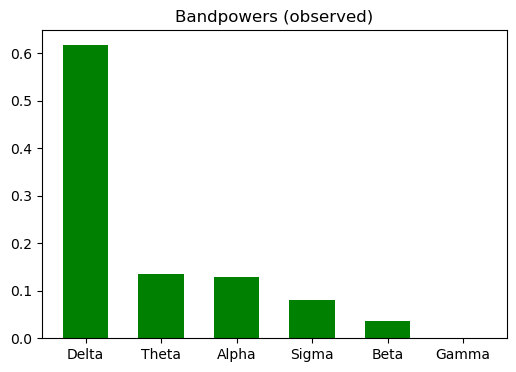

In [9]:
# Retrieve the bandpowers. 
bandpowers = list(json.loads(response_observed.json())['bandpowers'].values())
bandpowers_labels = list(json.loads(response_observed.json())['bandpowers'].keys())

# Display the bandpowers in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(6), bandpowers, width = 0.6, color = ['green'])
axes.set_xticks(range(6), labels = bandpowers_labels)
axes.set_title('Bandpowers (observed)');

In [10]:
# Display the feedback and score. 
print('Feedback: ' + str(json.loads(response_observed.json())['feedback']))
print('Score: ' + str(json.loads(response_observed.json())['score']))

Feedback: 1
Score: 0.12840530047492565


## **2. Predicted brain activity**

**Request:** To the *predicted_brain_activity* endpoint of the API, we send a multi-channel time series of preprocessed EEG data, as well as some parameters: the machine learning model that we would like to use, the specific voxel activity that we would like to predict, the type of NF regulation, and the NF threshold. 

**Response:** We retrieve the predicted values of the voxels, the feedback valence, and the NF score. 

In [11]:
# Identify the ECG channel index. 
ecg_channel_index = channels_data.ch_names.index('ECG')
ecg_channel_index

31

In [12]:
# Retrieve the number of channels. 
nb_channels = np_channels_data.shape[0]

# Transform the NumPy array into a list of sublists, excluding the ECG channel. 
# Here we use the first 12 seconds of data for all the electrodes (except ECG). Any other 12-second interval could be used. 
# This sequence duration of 12 seconds was used in the Neuropolis project for the training of the machine learning models. 
list_channels_data = []
for channel_index in range(nb_channels):
    if channel_index != ecg_channel_index:
        list_channels_data.append(list(np_channels_data[channel_index, 0:12*int(sampling_frequency)]))

In [13]:
# Define the URL. 
url_predicted_brain_activity = 'http://localhost:8000/neurofeedback/predicted_brain_activity'

# Define the dictionary. 
eeg_dict = {'eeg_data' :                 list_channels_data,  
            'trained_model' :            'LinearRegression', 
            'training_voxel' :           'pgACC', 
            'regulation' :               'upregulation',
            'threshold' :                0}

In [14]:
# Send the request to the API, and get the response. 
response_predicted = requests.post(url_predicted_brain_activity, json = eeg_dict)
response_predicted.json()

'{"voxels": [0.20303892233086943, 0.5311823143387286, 0.3076417897283916, -0.6095039649019828, -0.4232004950565343, -0.014029297702458782, 0.1413416663257568, -1.6311749286860364, 0.4166805124978203, 1.9757627119134047, 0.014656079610921136, -0.942693038347875, -0.29415260986358804, -0.881842231233406, -2.0507009930256626, -0.6434883121753492, -0.9050916935788502], "voxel_value": 0.20303892233086943, "feedback": 1, "score": 0.20303892233086943}'

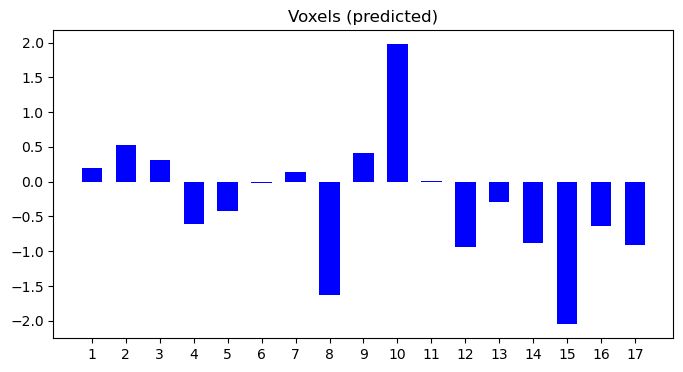

In [15]:
# Retrieve the predicted values of the voxels. 
voxels = json.loads(response_predicted.json())['voxels']

# Display the predicted values of the voxels in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))
axes.bar(range(17), voxels, width = 0.6, color = ['blue'])
axes.set_xticks(range(17), labels = range(1, 18))
axes.set_title('Voxels (predicted)');

In [16]:
# Display the feedback and score. 
print('Feedback: ' + str(json.loads(response_predicted.json())['feedback']))
print('Score: ' + str(json.loads(response_predicted.json())['score']))

Feedback: 1
Score: 0.20303892233086943
